# Øving 6 - TMA4320

* **Veiledning:** Digital. Onsdag 17. mars, 1015-1200, Mandag 22. mars, 1415-1600, Onsdag 24. mars, 1015-1200. 
* **Innleveringsfrist:** Fredag 26. mars, 2021, kl 2359
* **Innleveringsmetode** Følgende to krav er nødvendig for godkjenning
    1. Opplasting av Jupyter Notebook (individuelt) i Blackboard
    2. Svare på Blackboardskjema for kontrollspørsmålene i øvingen

I denne øvingen skal du lage en ODE-løser med skrittlengdekontroll. Den skal kunne løse generelle startverdiproblemer av formen

$$
      y' = f(t,y),\quad y(t_0)=y_0\quad\text{for}\ t\in[t_0,t_{end}]
$$

Man lager en funksjon som tar følgende input
* t0: Startpunktet (venstre endepunkt)
* tend: Sluttpunktet (høyre endepunkt)
* y0: Den gitte initialverdien i t0
* f: En funksjon som beskrevet nedenfor
* h0: En omtrentlig første tidsskrittlengde
* tol: En brukerspesifisert toleranse for lokalfeil

Funksjonen returnerer
* T: et numpy array med alle [t0,t1,...,tend], disse velges av funksjonen
* Y: En 2d numpy-matrise der rad k angir løsning ved tid $t=t_k$
* stats: en dictionary over interessant statistikk. For eksempel kan man ha nøklene 'steps' for antall skritt, 'fevals' for antall kall til funksjonen f, og 'rejects' for antall ganger skritt ble forkastet. Man kan selv velge hva slags informasjon man ellers vil legge inn i stats.

Inputfunksjonen f tar to inputargumenter, $t$ og $y$ der $t$ er et reelt tall og $y$ er et numpy-array med
lengde lik problemets dimensjon. Den returnerer et numpy-array av samme dimensjon som y som inneholder $f(t,y)$.

Metoden som benyttes er det innbygde paret av orden (3,2) som ble laget av Bogacki og Shampine og nevnt i timen.
Skritt $k$ med skrittlengde $h_k:=h$ utføres slik:

\begin{align*}
F_1 &= f(t_k,y_k) \\
F_2 &= f(t_{k}+\tfrac{1}{2}h, y_k+\tfrac{1}{2}h F_1) \\
F_3 &= f(t_k + \tfrac{3}{4}h, y_k+\tfrac{3}{4}h F_2) \\
y_{k+1} &= y_k + \frac{h}{9}(2F_1+3F_2+4F_3)
\end{align*}

Deretter beregnes nivået $F_4$ som en kan bruke som $F_1$ i det etterfølgende skrittet, samt en hjelpeapproksimasjon $\hat{y}_{k+1}$ til å finne estimat av lokalfeilen:

\begin{align*}
F_4 &= f(t_k+h, y_{k+1}) \\
\hat{y}_{k+1} &= y_k + \frac{h}{24}(7F_1+6F_2+8F_3+3F_4)
\end{align*}

Det lokale feilestimatet beregnes som

$$
\mathrm{est}_{k+1} = \hat{y}_{k+1} - y_{k+1}
$$

I tillegg fins en justeringsformel for skrittlengden fra ett skritt til et annet som gjennomgått i timene. Vi setter i dette tilfellet

$$
    h_{ny} = \alpha\cdot h \cdot \left(\frac{\mathtt{tol}}{\|\mathrm{est_{k+1}}\|}\right)^{1/3},\quad \alpha\approx 0.8-0.9
$$

$\alpha$ er en såkalt pessimistfaktor. Hvis den velges for liten så blir man veldig forsiktig, tar kortere skritt enn nødvendig og bruker dermed uforholdsmessig mange skritt. Hvis den velges for stor så kan det bli mange forkastede skritt. Man tar færre skritt, men bruker regnetid på å gjøre om igjen mange skritt.

$h_{ny}$ gitt ved formelen brukes når skrittet man tok ble forkastet og man prøver på nytt med kortere skrittlengde. Den brukes også som beregning av skrittlengde til neste skritt, dvs $h_k=h$ og $h_{k+1}=h_{ny}$ hvis skrittet ble akseptert.

Algoritmen kan beskrives som følger (tar ikke med statistikkinnsamling)

* Gitt $t_0, t_{end}, y_0, h_0, \mathtt{tol}, f$ som input
* $h=h_0$, $k=0$
* $F_1=f(t_0,y_0)$
* **while** $t_{end}-t_k>0$
    * $h=\min(h,t_{end}-t_k)$
    * $t_{k+1} = t_k+h$
    * $F_2, F_3, y_{k+1}$ beregnes fra formler ovenfor
    * $F_4=f(t_{k+1},y_{k+1})$ og $\hat{y}_{k+1}$ beregnes fra formelen ovenfor.
    * $\mathrm{normest}=\| \hat{y}_{k+1}-y_{k+1} \|$
    * **if** $\mathrm{normest} < \mathtt{tol}$ (aksepter skritt)
        * $k=k+1$
        * $F_1=F_4$
    * $h_{ny}$ beregnes fra oppgitt formel og sett $h=h_{ny}$.

Merk at enten skrittet forkastes eller aksepteres så brukes samme formel for å oppdatere skrittlengden $h$.

*Dynamisk allokering.* Et programteknisk problem som må løses er det faktum at du ikke vet størrelsen på arrayene $T$ og $Y$ apriori.
En løsning på problemet er å bruke numpy-funksjonen append. Normalt sett er slik dynamisk allokering tidkrevende og du bør unngå det dersom du kjenner lengden på array'ene a priori og kan allokere plassen f.eks. med
numpy.zeros i starten av programmet.


**Oppgave 1** Skriv koden og test den ut på det enkle problemet

$$
u'=v,\ v'=-4u,\quad u(0)=1,\ v(0)=0,\ [t_0,t_{end}]=[0,2\pi]
$$

som har eksakt løsning $u(t)=\cos 2t$ og $v(t)=-2\sin 2t$. Merk at her er $y(t)=[u(t),v(t)]^T$.

**Oppgave 2** Anvend rutinen på Brusselator-problemet nedenfor. Sett pessimistfaktor $\alpha=0.9$,
$t_0=0$, $t_{end}=20$, og $tol=10^{-5}$. La $h0=0.1$.

\begin{align*}
u' &= 1 + u^2 v - 4 u, & u(0)&=1 \\
v' &= 3u - u^2 v,  & v(0)&=2.9
\end{align*}

Lag et plott som viser hver av løsningskomponentene som funksjon av $t$ (i samme plott)
Suppler med et plott rett under dette som viser hvordan skrittlengden varierer med $t$.

**Kontrollspørsmål** Du blir her bedt om å rapportere statistikk fra eksperimentet i Oppgave 2.
Antall skritt koden din bruker, antall funksjonsevalueringer (feval) og antall forkastede skritt.

**Godkjenningskrav** Du må laste opp koden som en Jupyter notebook i Blackboard, og svare på kontrollspørsmålene.



Oppgave 1

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import time

# t0: Startpunktet (venstre endepunkt)
# tend: Sluttpunktet (høyre endepunkt)
# y0: Den gitte initialverdien i t0
# f: En funksjon som beskrevet nedenfor
# h0: En omtrentlig første tidsskrittlengde
# tol: En brukerspesifisert toleranse for lokalfeil
pessimismfactor = 0.9

def ODEsolver(f,y0,h0,t0,tend,tol):
    t1 = time.time()
    h,k = h0,0
#     t = [t0]
#     y = [y0]
    t = np.array([t0])
    y = np.zeros((1,2))
    y[0,:] = y0
    failsafe = 0
    F1 = f(t[k],y[k,:])#+1 fcalls
    stats = [1,0]#<-- therefore begins with 1
    while tend-t[k] > 0 and failsafe < 1000000:
        F2 = f(t[k] + 0.5*h,y[k,:] + 0.5*h*F1)
        F3 = f(t[k] + 0.75*h,y[k,:] + 0.75*h*F2)
        y_new = y[k,:] + h/9*(2*F1 + 3*F2 + 4*F3)
        F4 = f(t[k] + h,y_new)
        y_est = y[k,:] + h/24*(7*F1 + 6*F2 + 8*F3 + 3*F4)
        e_est = np.linalg.norm(y_est - y_new)
        if e_est < tol:
            t = np.append(t,t[k] + h)
            y = np.append(y,[y_new],axis = 0)
            k = k + 1
            F1 =F4
        else:
            stats[1] +=1
        h = pessimismfactor * h * (tol/e_est)**(1/3)
        failsafe += 1
        stats[0] += 3#siden funksjonen kalles 3 ganger per iterasjon
    print(f"Steps: {len(t)-1}, func calls: {stats[0]}, unaccepted sol: {stats[1]}")
    t2 = time.time()
    print(f'Real time elapsed = {t2-t1}')
    return t,y

Test 1

Steps: 206, func calls: 622, unaccepted sol: 1
Real time elapsed = 0.03999924659729004


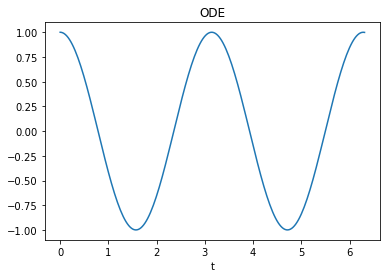

In [24]:
def RHS(t,vals):
    A = np.array([[0,1],[-4,0]])
    return A.dot(vals)
IC = np.array([1,0])
t,y = ODEsolver(RHS,IC,1,0,2*np.pi,1E-5)

plt.title("ODE")
plt.xlabel("t")
plt.plot(t,y[:,0])

Oppgave 2

Steps: 424, func calls: 1336, unaccepted sol: 21
Real time elapsed = 0.0830070972442627


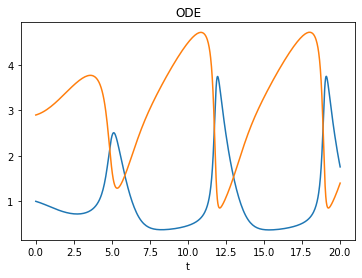

In [25]:
def RHS2(t,vals,):
    u = vals[0]
    v = vals[1]
    du = 1 + u**2*v - 4*u
    dv = 3*u - u**2*v
    return np.array([du,dv])

IC2 = np.array([1,2.9])

t,y = ODEsolver(RHS2,IC2,0.1,0,20,10**(-5))
plt.title("ODE")
plt.xlabel("t")
plt.plot(t,y[:,:])